In [53]:
!pip install plotnine


[notice] A new release of pip is available: 23.3.2 -> 24.3.1
[notice] To update, run: C:\Users\josep\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [6]:
import numpy as np
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [35]:
from plotnine import (  # Pour créer des visualisations
    ggplot, aes, geom_histogram, theme_bw, ylab, xlab, theme, element_text
)
import plotnine.options 

In [ ]:
### Objectif : pre-processing ###
# enlever les outliers ## Comment ?
# enlever les nan enlever les dropna

# On garde que ceux qui nous interesse: ceux avec une véritable représentation d'une saison. Ceux significatifs. 
#   les saisons sont déterminer sur les apparitions de commentaires (utiliser en tel ou tel saison) / Peut-on dire aussi que determiner avec les ingrédients pour ceux qui n'ont pas une saison satisfaisamment différentiable? 

# Understand the data

### Load the data

In [7]:
# To fetch the absolute path of the folder and then take all csv file.

folder_path = Path('c:\\Users\\josep\\Documents\\Telecom Paris\\Kit_Big_Data\\projet\\Data\\archive')
csv_files = [file.name for file in folder_path.glob('*.csv')]

def get_next_item(dict_data, index = 1):
    iterator = iter(dict_data.items())
    for i in range(1, index):
        print("ok")
        next(iterator)
    return next(iterator)

# Function to read all CSV files that start with "RAW"
def read_raw_files(csv_files, folder_path):
    raw_files_data = {}
    for file_name in csv_files:
        if file_name.startswith('RAW'):
            raw_files_data[file_name] = read_file(folder_path / file_name)
    
    return raw_files_data

def read_file(file_path):
    return pd.read_csv(file_path)

In [8]:
raw_data = read_raw_files(csv_files, folder_path)

In [9]:
file_name1, interaction = get_next_item(raw_data)
file_name2, recipe = get_next_item(raw_data, index=2)

ok


### Pre-process the data

In [49]:
def transform_date(date):
    return pd.to_datetime(date)

#---------------------------------------------------------------
### Seasons ###

def create_season(year):
    spring = pd.Timestamp(year=year, month=3, day=21)
    summer = pd.Timestamp(year=year, month=6, day=21)
    fall = pd.Timestamp(year=year, month=9, day=21)
    winter = pd.Timestamp(year=year, month=12, day=21)
    return spring, summer, fall, winter
    
def assign_season_date(date):
    ### assign the seasons for the year
    spring, summer, fall, winter = create_season(date.year)
    
    ### assign 
    if spring <= date < summer:
        return 'Spring'
    elif summer <= date < fall:
        return 'Summer'
    elif fall <= date < winter:
        return 'Fall'
    else:
        return 'Winter'

def modified_frequency(contigency_table):
    number_total_recipe_id = contigency_table.sum(axis=1)
    # numerator = numerator **2
    contigency_table = contigency_table ** 2
    contigency_table['count'] = pd.DataFrame(number_total_recipe_id)
    # numerator / total_nb_recipe
    freq_contigency_table = contigency_table.div(contigency_table['count'], axis=0).drop(columns='count')
    
    # aaply non linear transformation x / (eps + log(1 + x)). log transform to see even more the difference of values (and epsilon to not divide by 0)
    return freq_contigency_table

def filter_data_for_season(interaction, i = 3):
    recipe_season_count = interaction.groupby(['recipe_id', 'season']).size().reset_index(name='count')
    recipe_season_count = recipe_season_count.loc[recipe_season_count[recipe_season_count['count'] >= i].index]
    return recipe_season_count

def contigency_table(recipe_season_count):
    return pd.crosstab(recipe_season_count['recipe_id'], recipe_season_count['season'], values=recipe_season_count['count'], aggfunc='sum').fillna(0)

def determine_max_season(row, tolerance=1e-6):
    max_value = row.max()
    is_close = np.isclose(row, max_value, atol=tolerance)
    max_seasons = row[is_close].index.tolist()
    return np.random.choice(max_seasons)

def assign_season(interaction, recipe):
    # transform in dates
    #interaction['date'] = transform_date(interaction['date'])
    #recipe['submitted'] = transform_date(recipe['submitted'])
    
    # assign the season
    interaction_filtered = interaction.copy()
    interaction_filtered['season'] = interaction_filtered['date'].apply(assign_season_date)
    # keep only the recipes with season for i number
    ''''''
    recipe_season_count = filter_data_for_season(interaction_filtered)
    contigency_table = contigency_table(recipe_season_count)
    contigency_table = modified_frequency(contigency_table)

    # re-assign
    recipe = recipe[recipe['id'].isin(contigency_table.index)]
    interaction = interaction[interaction['recipe_id'].isin(contigency_table.index)]

    # assign season
    recipe['season'] = recipe["id"].map(contigency_table.apply(determine_max_season, axis=1))
    return interaction, recipe 

def preprocess_data(interaction, recipe):
    # transform in dates
    interaction['date'] = transform_date(interaction['date'])
    recipe['submitted'] = transform_date(recipe['submitted'])
    
    
    
    return interaction, recipe 
    
#---------------------------------------------------------------
### Visualisation ###

def show_year(dataset, colonne, recipe_id):
    data = dataset[dataset[colonne] == recipe_id]

    plt.figure(figsize=(12, 6))
    sns.barplot(x='season', y='count', data=data, palette='Set2')
    plt.title(f"Utilisation de la recette {recipe_id} par saison for all years.")
    plt.xlabel('Saison')
    plt.ylabel('Nombre d\'utilisations')
    plt.legend(title="Saison")
    plt.show()

In [33]:
interaction, recipe = preprocess_data(interaction, recipe)

In [34]:
interaction

,user_id,recipe_id,date,rating,review
0,38094,40893,2003-02-17,4,Great with a salad. Cooked on top of stove for...
1,1293707,40893,2011-12-21,5,"So simple, so delicious! Great for chilly fall..."
2,8937,44394,2002-12-01,4,This worked very well and is EASY. I used not...
3,126440,85009,2010-02-27,5,I made the Mexican topping and took it to bunk...
4,57222,85009,2011-10-01,5,"Made the cheddar bacon topping, adding a sprin..."
...,...,...,...,...,...
1132362,116593,72730,2003-12-09,0,Another approach is to start making sauce with...
1132363,583662,386618,2009-09-29,5,These were so delicious! My husband and I tru...
1132364,157126,78003,2008-06-23,5,WOW! Sometimes I don't take the time to rate ...
1132365,53932,78003,2009-01-11,4,Very good! I used regular port as well. The ...


1 identifier les outliers pour chaque variable. 
- boxplot 
- ecart interquartile (IQR)

supprimer? remplacer ? garder ?


In [12]:
recipe.describe()
# on s'en fiche des contributor_id et id des recettes vu que cela ne veut rien dire, ces variables servent d'indication.
# Il faut regarder cette histoire de steps: utiliser le truc cecile. EN PARLER (ici je le supprime et le lui demande ce qu'elle veut faire)
# supprimer les nb d'ingrédient ou temps de cuisson trop importants ? 

,id,minutes,contributor_id,submitted,n_steps,n_ingredients
count,231637.000000,2.316370e+05,2.316370e+05,231637,231637.000000,231637.000000
mean,222014.708984,9.398546e+03,5.534885e+06,2006-11-14 01:58:34.925508096,9.765499,9.051153
min,38.000000,0.000000e+00,2.700000e+01,1999-08-06 00:00:00,0.000000,1.000000
25%,99944.000000,2.000000e+01,5.690500e+04,2004-09-16 00:00:00,6.000000,6.000000
50%,207249.000000,4.000000e+01,1.736140e+05,2007-01-23 00:00:00,9.000000,9.000000
75%,333816.000000,6.500000e+01,3.982750e+05,2008-10-29 00:00:00,12.000000,11.000000
max,537716.000000,2.147484e+09,2.002290e+09,2018-12-04 00:00:00,145.000000,43.000000
std,141206.635626,4.461963e+06,9.979141e+07,NaN,5.995128,3.734796


In [13]:
## We are checking here whether or not which recipes to keep regarding when they are submitted. those su

In [17]:
interaction_filtered = interaction.copy()
interaction_filtered['season'] = interaction_filtered['date'].apply(assign_season_date)

In [18]:
interaction_filtered

,user_id,recipe_id,date,rating,review,season
0,38094,40893,2003-02-17,4,Great with a salad. Cooked on top of stove for...,Winter
1,1293707,40893,2011-12-21,5,"So simple, so delicious! Great for chilly fall...",Winter
2,8937,44394,2002-12-01,4,This worked very well and is EASY. I used not...,Fall
3,126440,85009,2010-02-27,5,I made the Mexican topping and took it to bunk...,Winter
4,57222,85009,2011-10-01,5,"Made the cheddar bacon topping, adding a sprin...",Fall
...,...,...,...,...,...,...
1132362,116593,72730,2003-12-09,0,Another approach is to start making sauce with...,Fall
1132363,583662,386618,2009-09-29,5,These were so delicious! My husband and I tru...,Fall
1132364,157126,78003,2008-06-23,5,WOW! Sometimes I don't take the time to rate ...,Summer
1132365,53932,78003,2009-01-11,4,Very good! I used regular port as well. The ...,Winter


In [ ]:
# afficher pour regarder la trend des recettes en fonction des saisons =>
# reprensation d'une recette en fonction des années et des saisons.
# pour ceux qui ont toujours une meme tendance majoritairement => easy peasy
# les autres => assigne par rapport à un autre critère ou just ela saisons majoritaire. 

# => assigner les saisons 
# ET enlever pas suffisamment de réprésentation. (
    # par recette on a le count globale => on montre un histogramme ou boxplot pour savoir les outliers. enlève les outliers)
# ceux qui sont difficiles a assigner ont réfléchit à l'inytérêt de les inclures. 

In [51]:
def remove_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data[(data[column] <= upper_bound)]#(data[column] >= lower_bound])#& (data[column] <= upper_bound)]

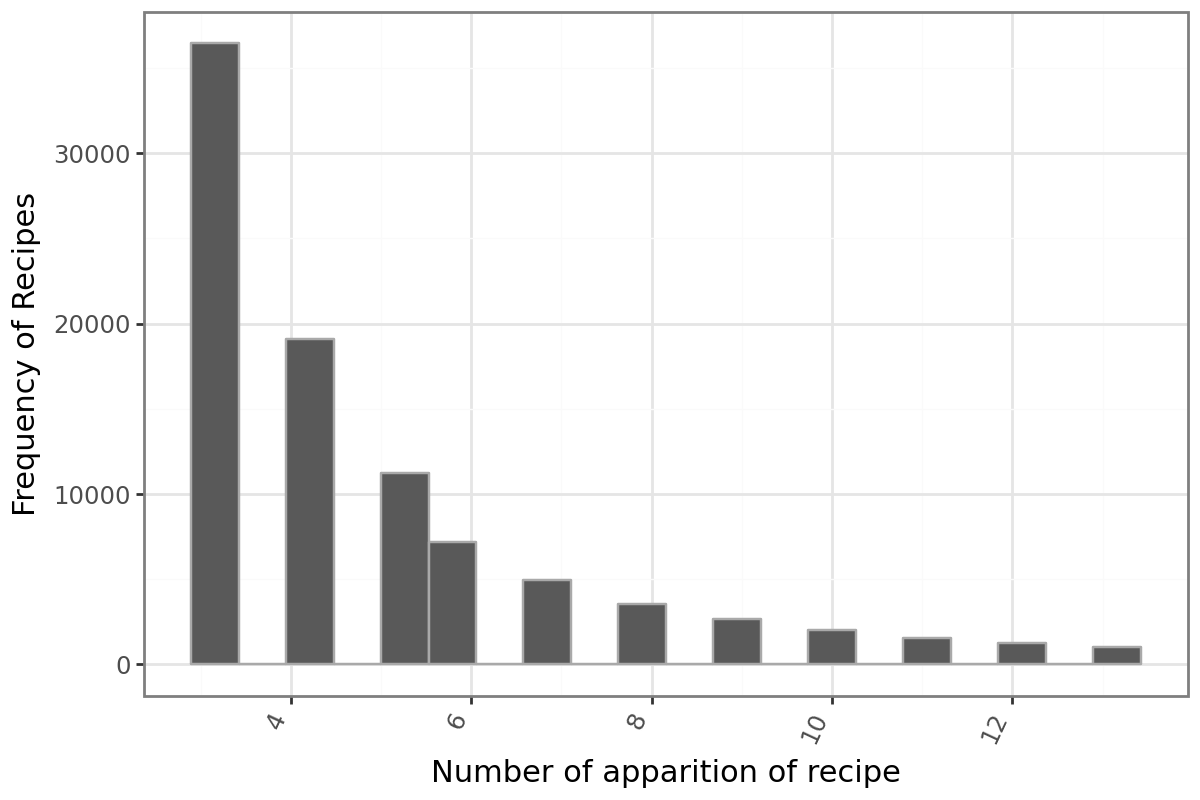

In [52]:
recipe_counts = filter_data_for_season(interaction_filtered)
recipe_counts = remove_outliers_iqr(recipe_counts, 'count')
plotnine.options.dpi = 100
plotnine.options.figure_size=(6,4)
(ggplot(recipe_counts)
 + geom_histogram(aes(x="count"), bins=20, color="darkgray", show_legend=False)
 + theme_bw()
 + ylab("Frequency of Recipes")
 + xlab("Number of apparition of recipe")
 + theme(axis_text_x=element_text(rotation=65, hjust=1))
)

In [43]:
interaction_filtered['season'].isna().any()

False

In [45]:
from plotnine import ggplot, aes, geom_bar, theme_bw, ylab, xlab, theme, element_text, scale_x_continuous
def plot_season_distribution(interaction_filtered):
    """
    Crée un graphique de barres empilées normalisées pour afficher la répartition des saisons par année.

    Parameters:
    interaction_filtered (pd.DataFrame): DataFrame contenant les colonnes 'year' et 'season'.

    Returns:
    ggplot object: Graphique de barres empilées normalisées.
    """
    interaction_filtered['year'] = interaction_filtered['date'].dt.year
    # Calcul des proportions pour chaque saison par année
    season_distribution = (
        interaction_filtered.groupby(['year', 'season'])
        .size()
        .reset_index(name='count')
    )
    print(interaction_filtered['year'].isna().any())
    # Calcul des totaux par année
    season_distribution['total'] = season_distribution.groupby('year')['count'].transform('sum')
    season_distribution['fraction_using'] = season_distribution['count'] / season_distribution['total']
    # Ordre des saisons (si nécessaire pour cohérence des couleurs)
    season_order = ['Winter', 'Spring', 'Summer', 'Fall']
    season_distribution['season'] = pd.Categorical(season_distribution['season'], categories=season_order, ordered=True)

    # Création du graphique
    plot = (
        ggplot(season_distribution)
        + aes(x='year', y='fraction_using', fill='season')
        + geom_bar(stat='identity', position='fill')
        + theme_bw()
        + ylab("Proportion of Recipes")
        + xlab("Year")
        + theme(axis_text_x=element_text(rotation=65, hjust=1))
        + scale_x_continuous(breaks=np.arange(season_distribution['year'].min(), season_distribution['year'].max() + 1))
    )
    return plot

False


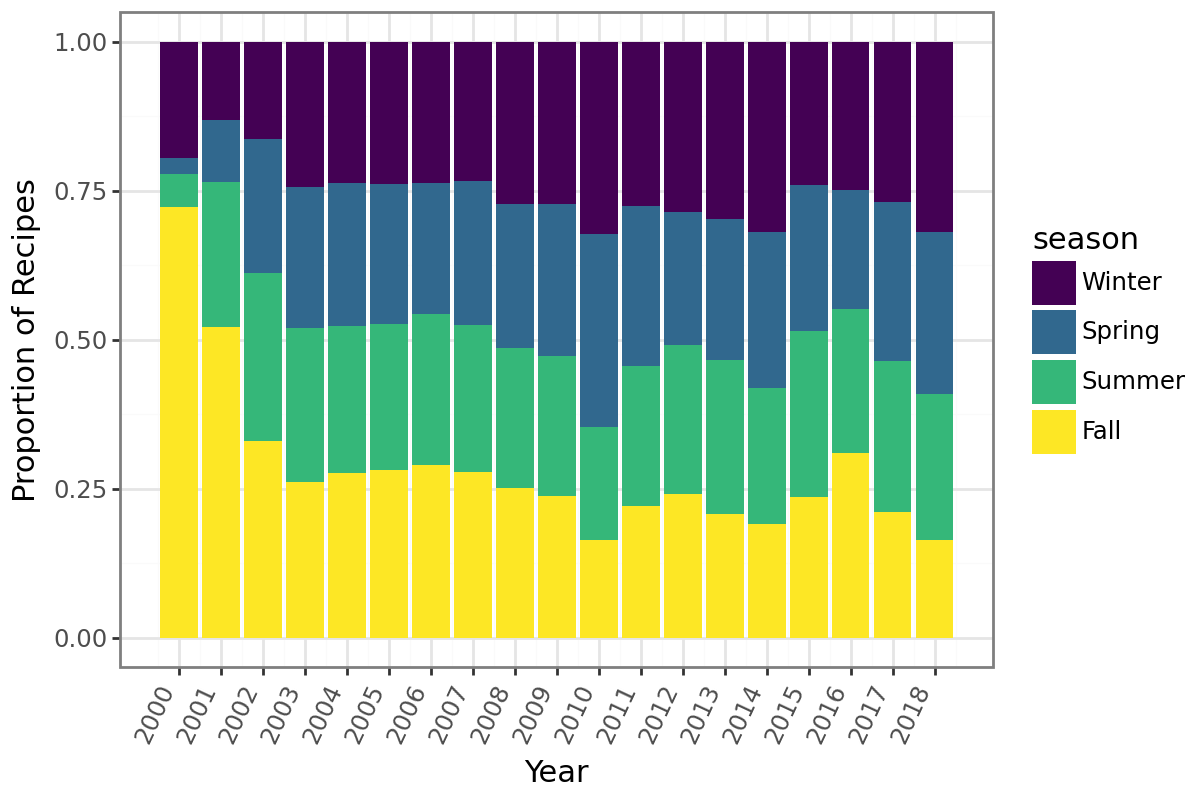

In [46]:
plot_season_distribution(interaction_filtered)

In [ ]:
# marque de post 
# 5 

In [47]:
def plot_interactions_by_year(interaction_filtered):
    """
    Plots the number of interactions (comments) per year.

    Parameters:
    interaction_filtered (pd.DataFrame): A DataFrame containing a 'date' column in datetime format.

    Returns:
    ggplot object: A bar chart representing the number of interactions by year.
    """
    # Extract the year from the 'date' column
    interaction_filtered['year'] = interaction_filtered['date'].dt.year

    # Group by year and count the number of interactions
    interactions_by_year = (
        interaction_filtered.groupby('year')
        .size()
        .reset_index(name='count')
    )

    # Create the bar plot
    plot = (
        ggplot(interactions_by_year)
        + aes(x='year', y='count')
        + geom_bar(stat='identity', fill='blue', color='darkgray')
        + theme_bw()
        + ylab("Number of Interactions")
        + xlab("Year")
        + theme(axis_text_x=element_text(rotation=65, hjust=1))
        + scale_x_continuous(breaks=interactions_by_year['year'].unique())
    )
    return plot

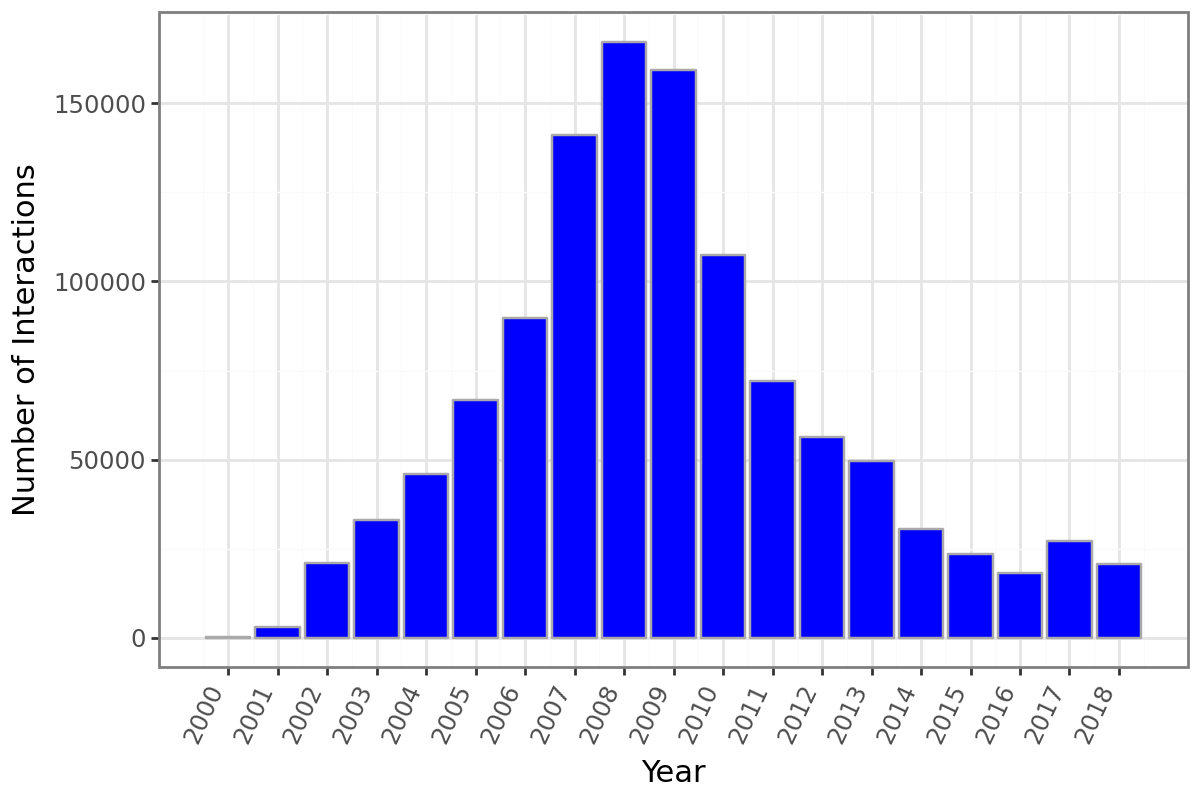

In [48]:
plot_interactions_by_year(interaction_filtered)

In [ ]:
# Ce qu'on observe c'est que: les recettes sont pas bcp utilisées.
# important nombre autour de un seul commentaire. 
# et quand on eleve celles qui sont utilisé plus de 45 fois => presque un log  
## après avoir enlever ceux trop grands qui fausserait les donénes, on va regarder pour ces recipe_id si elles ont tendances a etre plus en été , autonne ou hiver ou printemps.

In [ ]:
# reprensation d'une recette en fonction des années et des saisons.

In [ ]:
def transform_date(date):
    return pd.to_datetime(date)

#---------------------------------------------------------------
### Seasons ###

def create_season(year):
    spring = pd.Timestamp(year=year, month=3, day=21)
    summer = pd.Timestamp(year=year, month=6, day=21)
    fall = pd.Timestamp(year=year, month=9, day=21)
    winter = pd.Timestamp(year=year, month=12, day=21)
    return spring, summer, fall, winter
    
def assign_season_date(date):
    ### assign the seasons for the year
    spring, summer, fall, winter = create_season(date.year)
    
    ### assign 
    if spring <= date < summer:
        return 'Spring'
    elif summer <= date < fall:
        return 'Summer'
    elif fall <= date < winter:
        return 'Fall'
    else:
        return 'Winter'

def modified_frequency(contigency_table):
    number_total_recipe_id = contigency_table.sum(axis=1)
    # numerator = numerator **2
    contigency_table = contigency_table ** 2
    contigency_table['count'] = pd.DataFrame(number_total_recipe_id)
    # numerator / total_nb_recipe
    freq_contigency_table = contigency_table.div(contigency_table['count'], axis=0).drop(columns='count')
    
    # aaply non linear transformation x / (eps + log(1 + x)). log transform to see even more the difference of values (and epsilon to not divide by 0)
    return freq_contigency_table

def filter_data_for_season(interaction, i = 10):
    recipe_season_count = interaction.groupby(['recipe_id', 'season']).size().reset_index(name='count')
    recipe_season_count = recipe_season_count.loc[recipe_season_count[recipe_season_count['count'] >= i].index]
    return pd.crosstab(recipe_season_count['recipe_id'], recipe_season_count['season'], values=recipe_season_count['count'], aggfunc='sum').fillna(0)

def determine_max_season(row, tolerance=1e-6):
    max_value = row.max()
    is_close = np.isclose(row, max_value, atol=tolerance)
    max_seasons = row[is_close].index.tolist()
    return np.random.choice(max_seasons)

def assign_season(interaction, recipe):
  
    # assign the season
    interaction_filtered = interaction.copy()
    interaction_filtered['season'] = interaction_filtered['date'].apply(assign_season_date)
    # keep only the recipes with season for i number
    contigency_table = filter_data_for_season(interaction_filtered)
    contigency_table = modified_frequency(contigency_table)

    # re-assign
    recipe = recipe[recipe['id'].isin(contigency_table.index)]
    interaction = interaction[interaction['recipe_id'].isin(contigency_table.index)]

    # assign season
    recipe['season'] = recipe["id"].map(contigency_table.apply(determine_max_season, axis=1))
    return interaction, recipe 


#---------------------------------------------------------------
### Visualisation ###

def show_year(dataset, colonne, recipe_id):
    data = dataset[dataset[colonne] == recipe_id]

    plt.figure(figsize=(12, 6))
    sns.barplot(x='season', y='count', data=data, palette='Set2')
    plt.title(f"Utilisation de la recette {recipe_id} par saison for all years.")
    plt.xlabel('Saison')
    plt.ylabel('Nombre d\'utilisations')
    plt.legend(title="Saison")
    plt.show()

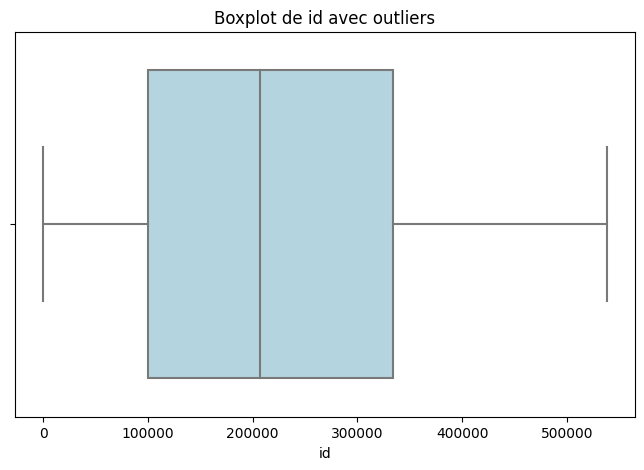

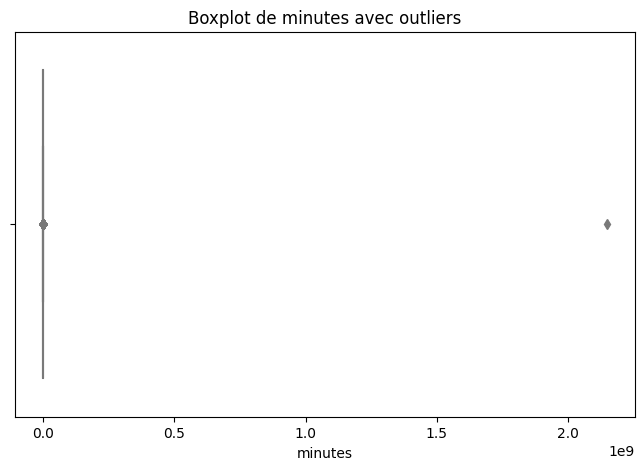

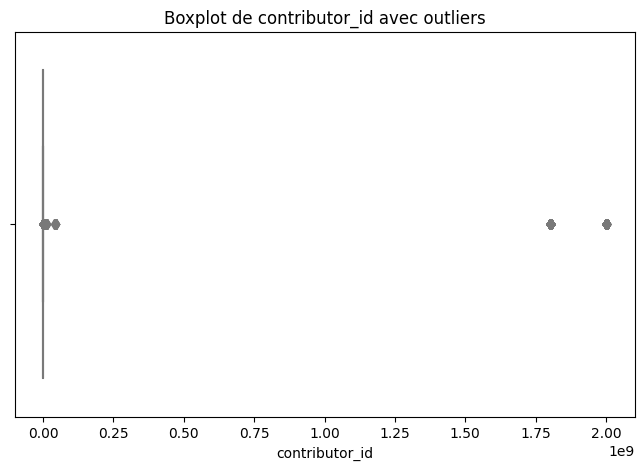

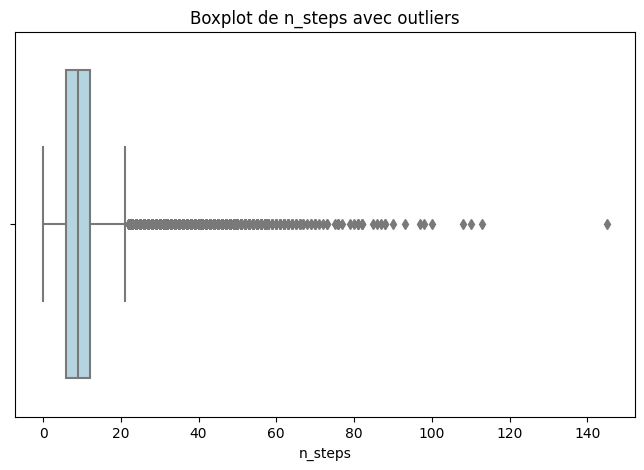

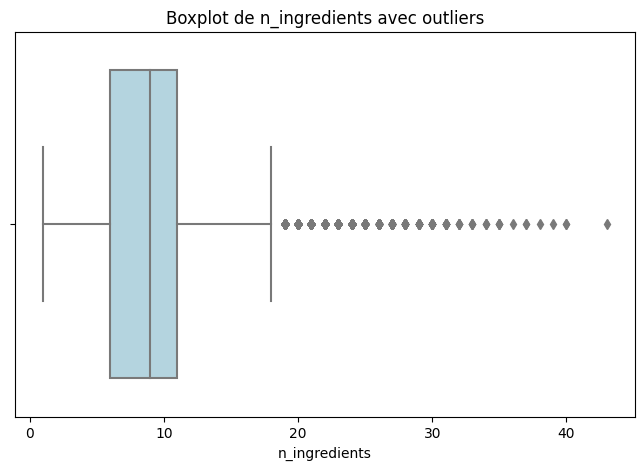

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import zscore, pearsonr, spearmanr

data = recipe
# Vérification des outliers
def detect_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data[(data[column] < lower_bound) | (data[column] > upper_bound)]

# Vérifier tous les outliers
outliers = {col: detect_outliers_iqr(data, col) for col in data.select_dtypes(include=np.number).columns}

for col in data.select_dtypes(include=np.number).columns:
    plt.figure(figsize=(8, 5))
    sns.boxplot(data=data, x=col, color="lightblue")
    plt.title(f"Boxplot de {col} avec outliers")
    plt.xlabel(col)
    plt.show()

C:\Users\josep\AppData\Local\Temp\ipykernel_19548\4220429481.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = data.corr()  # Pearson par défaut


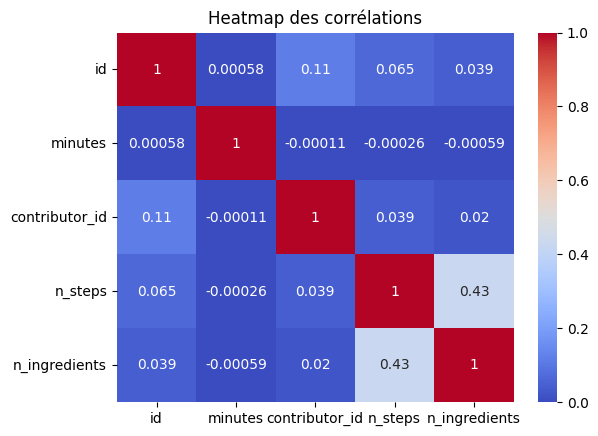

Corrélation entre id et minutes: 0.0005818031741331461 (p-value: 0.7794677534053572)
Corrélation entre id et contributor_id: 0.1143232469033266 (p-value: 0.0)
Corrélation entre id et n_steps: 0.06451189249106047 (p-value: 4.3597575907298255e-212)
Corrélation entre id et n_ingredients: 0.03922748524836988 (p-value: 1.463520544669442e-79)
Corrélation entre minutes et id: 0.0005818031741331461 (p-value: 0.7794677534053572)
Corrélation entre minutes et contributor_id: -0.00010538088837073282 (p-value: 0.9595501066749755)
Corrélation entre minutes et n_steps: -0.00025737568163042724 (p-value: 0.90141752864158)
Corrélation entre minutes et n_ingredients: -0.0005920704805947786 (p-value: 0.7756792277114806)
Corrélation entre contributor_id et id: 0.1143232469033266 (p-value: 0.0)
Corrélation entre contributor_id et minutes: -0.00010538088837073282 (p-value: 0.9595501066749755)
Corrélation entre contributor_id et n_steps: 0.03856878537960731 (p-value: 5.67746916324561e-77)
Corrélation entre co

In [ ]:

# Matrice de corrélation
correlation_matrix = data.corr()  # Pearson par défaut
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.title("Heatmap des corrélations")
plt.show()

# Analyse des relations spécifiques
for col1 in data.select_dtypes(include=np.number).columns:
    for col2 in data.select_dtypes(include=np.number).columns:
        if col1 != col2:
            corr, p_value = pearsonr(data[col1].dropna(), data[col2].dropna())
            print(f"Corrélation entre {col1} et {col2}: {corr} (p-value: {p_value})")

On part sur de la recommandation de recette =>
- identifier  utilisateurs avec des comportements d'interaction atypiques(ex. : un utilisateur (qui donne toujours la même note indépendamment de la recette)
- Détecter des recettes qui ont des caractéristiques) inhabituelles (ex. : temps de préparation et nutrition incohérents avec le type de recette)


-> les recettes rapides sont elles les plus populaire ?
-> rectte le plus longues / nb de steps eleves les mieux notés (car plus elaborés)?
-> des tags : 

Mais on a un problème : comment faire si une recette a très peu de commentaires? ou exactement le même nombre de commentaire par saisons ?
les recettes qui ont très peu de commentaires ? Si on les enleve est-ce que c'est mieux ?
celles qui ont le même nombre de commentaire par saisons => peut faire une moyenne en fonction de plusieurs années, ou alors au hasard. 

1. Pour chaque utilisation de ingrédient => associer une saison (création nouvelle colonne)
2. Pour un recipe je regarde pour une année le moment de son pic d'utilisation (quelle saison il est utilisé le plus)
3. pour tout les recipe qui sont utilisé a une certaines saison (on prends pas en compte les autres qui n'apporte rien) on regarde leur temps de cuisson. Corrélation ou non avec les saisons ? (en gros en hiver les recettes sont elles ou non plus longue ? )

### En fonction des saisons 
- Printemps : 21 mars - 20 juin
- Été : 21 juin - 20 septembre
- Automne : 21 septembre - 20 décembre
- Hiver : 21 décembre - 20 mars

In [ ]:
### Preprocess the data

interaction_filtered, recipe_filtered = assign_season(interaction, recipe)

C:\Users\josep\AppData\Local\Temp\ipykernel_25576\2029797861.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recipe['season'] = recipe["id"].map(contigency_table.apply(determine_max_season, axis=1))


In [ ]:
recipe_filtered.to_csv('recipe_filtrered.csv', index=False)

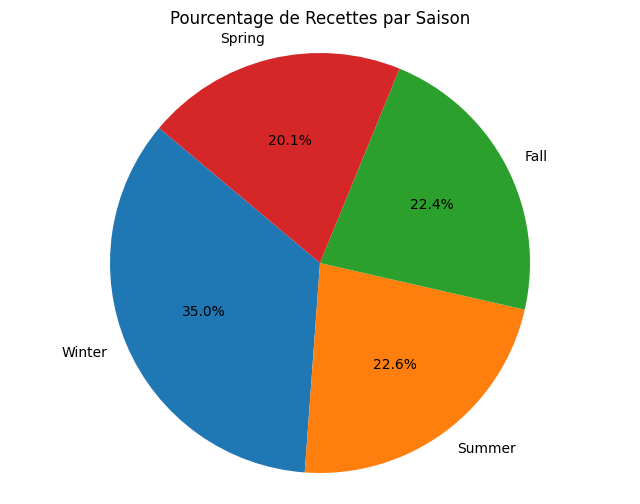

In [ ]:
season_counts = recipe_filtered['season'].value_counts().reset_index()
season_counts.columns = ['season', 'count']
season_counts['percentage'] = (season_counts['count'] / season_counts['count'].sum()) * 100

# Étape 3 : Tracer un camembert
plt.figure(figsize=(8, 6))
plt.pie(season_counts['percentage'], labels=season_counts['season'], autopct='%1.1f%%', startangle=140)
plt.title('Pourcentage de Recettes par Saison')
plt.axis('equal')  # Un cercle
plt.show()

In [ ]:
count, mean, std, min, _25, _50, _75, max = interaction['recipe_id'].value_counts().describe()
print(f'count {count}\nmean  {mean}\nstd   {std}\nmin   {min}\n_25   {_25}\n_50   {_50}\n_75   {_75}\nmax   {max}')

# filtered en fonction de leur nombre d'apparition
recipe_count = interaction['recipe_id'].value_counts()
interaction_filtered = interaction[~interaction['recipe_id'].isin(recipe_count[recipe_count <= _75].index)]

count 231637.0
mean  4.888541122532238
std   17.53248137712231
min   1.0
_25   1.0
_50   2.0
_75   4.0
max   1613.0


In [ ]:
result_transformed1.loc[40]

NameError: name 'result_transformed1' is not defined

In [ ]:
# top 3 des recettes en hivers, automne, été et printemps
result_transformed.apply(lambda x: x.nlargest(3).index.tolist(), axis = 0)

,Fall,Spring,Summer,Winter
0,2571,19396,2827,565
1,12735,22056,9793,8637
2,13501,22462,11208,10112


In [ ]:
def determine_max_season(row, tolerance=1e-6):
    max_value = row.max()
    print("max val is: ", max_value, "\n")
    
    # check if another close
    is_close = np.isclose(row, max_value, atol=tolerance)
    num_max_values = np.sum(is_close)
    print(is_close)
    if num_max_values > 1:
        raise ValueError(f"Valeurs maximales égales trouvées pour la recipe: {row.name}")
    
    return row.idxmax() 


In [ ]:
try:
    result_transformed['saison'] = result_transformed.apply(determine_max_season, axis=1)
except ValueError as e:
    print(e)

max val is:  0.2794246842044278 

[False False False  True]
max val is:  0.2880663990760595 

[False  True False False]
max val is:  0.36587083601536396 

[False False False  True]
max val is:  0.31454915735014854 

[False  True False False]
max val is:  0.2552987138551845 

[False  True  True  True]
Valeurs maximales égales trouvées pour la recipe: 66


In [ ]:
result_transformed.loc[66]

Fall      0.234104
Spring    0.255299
Summer    0.255299
Winter    0.255299
Name: 66, dtype: float64

In [ ]:
# top 3 des recettes en hivers, automne, été et printemps
frequence_recipe.apply(lambda x: x.nlargest(3).index.tolist(), axis = 0)

,Fall,Spring,Summer,Winter
0,27208,67256,9272,39087
1,25730,2886,2886,22782
2,339453,89204,50719,89204


Pour choisir le bon type de corrélation :
- Si tes données sont numériques continues, Pearson.
- Si elles sont ordinales ou non-linéaires, Spearman.
- Si tes données sont catégorielles, le test du chi carré.

In [ ]:
# chi carré
from scipy.stats import chi2_contingency
chi2, p_value, dof, expected = chi2_contingency(contingency_table)
# Afficher les résultats
print(f"Chi2 statistic: {chi2}")
print(f"p-value: {p_value}")
print(f"Degrees of freedom: {dof}")

Chi2 statistic: 307752.6914652008
p-value: 0.0
Degrees of freedom: 160776


### ATTENTION  

cette corrélation me parait extrèmement suspecte ! (même corrélation même si je prends toutes les données. Est-ce à cause des extrèmes?)

In [ ]:
recipe_peak_season = recipe_season_count.loc[recipe_season_count.groupby('recipe_id')['count'].idxmax()]
recipe_peak_season = recipe_peak_season.rename(columns={'recipe_id': 'id'})
recipe_peak_season

,id,season,count
3,40,Winter,3
5,49,Spring,7
10,58,Winter,3
12,62,Spring,9
16,66,Spring,5
...,...,...,...
179279,534955,Winter,6
179280,535431,Spring,6
179282,535779,Summer,9
179283,536119,Summer,8


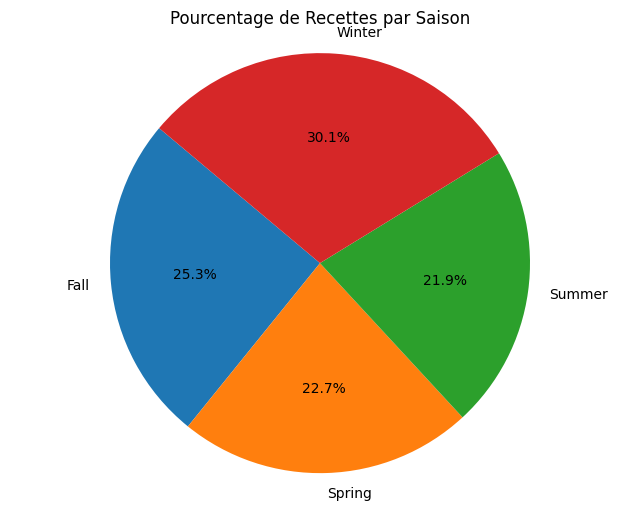

In [ ]:
# camember pour pourcentage par saison 

# Étape 1 : Regrouper les données par saison et compter le nombre total de recettes
season_counts = recipe_peak_season.groupby('season')['count'].sum().reset_index()

# Étape 2 : Calculer les pourcentages
season_counts['percentage'] = (season_counts['count'] / season_counts['count'].sum()) * 100

# Étape 3 : Tracer un camembert
plt.figure(figsize=(8, 6))
plt.pie(season_counts['percentage'], labels=season_counts['season'], autopct='%1.1f%%', startangle=140)
plt.title('Pourcentage de Recettes par Saison')
plt.axis('equal')  # Pour s'assurer que le camembert est un cercle
plt.show()


In [ ]:
### je veux le dataset des recettes avec des pic seasons

filtered_recipes = recipe[recipe['id'].isin(recipe_peak_season['id'])]

# Étape 2 : Merge pour ajouter la colonne 'pic_season'
filtered_recipes = filtered_recipes.merge(recipe_peak_season[['id', 'season']], on='id', how='left')

# Vérification du résultat
filtered_recipes

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients,season
0,beat this banana bread,75452,70,15892,2003-11-04,"['weeknight', 'time-to-make', 'course', 'main-...","[2669.3, 160.0, 976.0, 107.0, 62.0, 310.0, 138.0]",12,"['preheat oven to 350 degrees', 'butter two 9x...",from ann hodgman's,"['sugar', 'unsalted butter', 'bananas', 'eggs'...",9,Spring
1,better than sex strawberries,42198,1460,41531,2002-10-03,"['weeknight', 'time-to-make', 'course', 'main-...","[734.1, 66.0, 199.0, 10.0, 10.0, 117.0, 28.0]",8,['crush vanilla wafers into fine crumbs and li...,simple but sexy. this was in my local newspape...,"['vanilla wafers', 'butter', 'powdered sugar',...",7,Summer
2,better then bush s baked beans,67547,2970,85627,2003-07-26,"['weeknight', 'time-to-make', 'course', 'main-...","[462.4, 28.0, 214.0, 69.0, 14.0, 29.0, 23.0]",9,['in a very large sauce pan cover the beans an...,i'd have to say that this is a labor of love d...,"['great northern bean', 'chicken bouillon cube...",13,Winter
3,chicken lickin good pork chops,63986,500,14664,2003-06-06,"['weeknight', 'time-to-make', 'course', 'main-...","[105.7, 8.0, 0.0, 26.0, 5.0, 4.0, 3.0]",5,"['dredge pork chops in mixture of flour , salt...",here's and old standby i enjoy from time to ti...,"['lean pork chops', 'flour', 'salt', 'dry must...",7,Summer
4,chile rellenos,43026,45,52268,2002-10-14,"['60-minutes-or-less', 'time-to-make', 'course...","[94.0, 10.0, 0.0, 11.0, 11.0, 21.0, 0.0]",9,"['drain green chiles', 'sprinkle cornstarch on...",a favorite from a local restaurant no longer i...,"['egg roll wrap', 'whole green chilies', 'chee...",5,Winter
...,...,...,...,...,...,...,...,...,...,...,...,...,...
53588,zuppa toscana soup olive garden clone,208429,60,346694,2007-01-30,"['60-minutes-or-less', 'time-to-make', 'course...","[432.8, 32.0, 29.0, 39.0, 42.0, 39.0, 15.0]",10,['bring chicken stock and water to a light boi...,i have tried quite a few different recipes tha...,"['chicken stock', 'bacon', 'onion white', 'rus...",14,Winter
53589,zurie s overnight no knead bread,196201,70,200862,2006-11-18,"['time-to-make', 'course', 'main-ingredient', ...","[1379.6, 5.0, 12.0, 194.0, 79.0, 3.0, 96.0]",82,"[""since first making this bread according to t...","after posting this recipe, and making the brea...","['white bread flour', 'instant yeast', 'sugar'...",5,Winter
53590,zwiebelkuchen southwest german onion cake,103312,75,161745,2004-11-03,"['time-to-make', 'course', 'main-ingredient', ...","[864.1, 87.0, 30.0, 18.0, 40.0, 152.0, 23.0]",10,"['for the dough:', 'dissolve the yeast in the ...",this is a traditional late summer early fall s...,"['fresh yeast', 'milk', 'flour', 'butter', 'eg...",13,Fall
53591,zydeco soup,486161,60,227978,2012-08-29,"['ham', '60-minutes-or-less', 'time-to-make', ...","[415.2, 26.0, 34.0, 26.0, 44.0, 21.0, 15.0]",7,"['heat oil in a 4-quart dutch oven', 'add cele...",this is a delicious soup that i originally fou...,"['celery', 'onion', 'green sweet pepper', 'gar...",22,Summer


In [ ]:
[~interaction['recipe_id'].isin(recipe_count[recipe_count <= _75].index)
[~filtered_recipes[['minutes', 'season']].isin(filtered_recipes['season' == 'Spring'])

,minutes,season
0,70,Spring
1,1460,Summer
2,2970,Winter
3,500,Summer
4,45,Winter
...,...,...
53588,60,Winter
53589,70,Winter
53590,75,Fall
53591,60,Summer


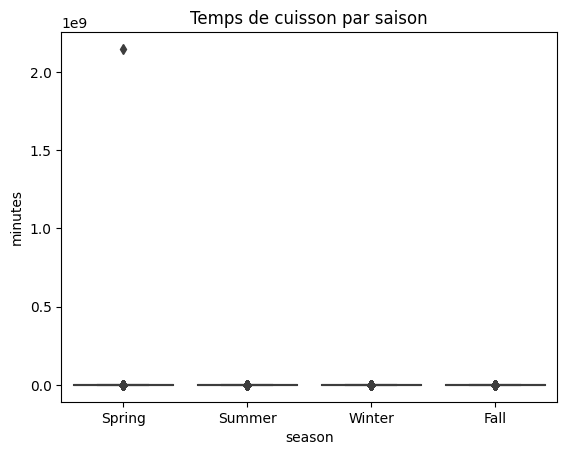

In [ ]:
import seaborn as sns

# Créer un boxplot pour visualiser la relation entre la saison et le temps de cuisson
sns.boxplot(x='season', y='minutes', data=])
plt.title("Temps de cuisson par saison")
plt.show()


In [ ]:
# Manière de comparer variable numérique et catégorielle (ANOVA)

In [ ]:
contingency_table = pd.crosstab(recipe_season_count['recipe_id'], recipe_season_count['season'], values=recipe_season_count['count'], aggfunc='sum').fillna(0)

contingency_table_cooking_time = pd.crosstab(filtered_recipes['minutes'], filtered_recipes['season'])